In [3]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

In [4]:
spark = (
  SparkSession.builder
    .appName("Codeway")
    .master("local[*]")
    .config("spark.driver.memory", "4g")
    .getOrCreate()
)

# Load the Models

In [5]:
from pyspark.ml import PipelineModel

bestModelMean = PipelineModel.load("/Users/macbookpro/PyCharmMiscProject/models/cohort_mean_model")
bestModelStd  = PipelineModel.load("/Users/macbookpro/PyCharmMiscProject/models/cohort_std_model")

# Read the Dataframes

In [6]:
# re-load the static preds
cohortPreds = spark.read.parquet("/Users/macbookpro/PyCharmMiscProject/Output_Dataframes/cohort_preds.parquet")

In [7]:
from pyspark.ml import PipelineModel
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import GBTRegressionModel
import pandas as pd
import matplotlib.pyplot as plt

In [8]:
test = spark.read.json("/Users/macbookpro/PyCharmMiscProject/test_set/cohort_test_set")

# Cohort-level Featur (Mean Model) Importance

In [9]:
# ——— Load saved pipelines ———
bestModelMean = PipelineModel.load("/Users/macbookpro/PyCharmMiscProject/models/cohort_mean_model")

In [10]:
bestModelMean.transform(test.limit(1)).select("features").printSchema()

root
 |-- features: vector (nullable = true)



In [11]:
# pull out the GBT stage
gbt_mean = next(s for s in bestModelMean.stages
                if isinstance(s, GBTRegressionModel))

# use the test set
feat_df = bestModelMean.transform(test.limit(1)).select("features")

# read feature names from metadata
meta = feat_df.schema["features"].metadata
attrs = meta["ml_attr"]["attrs"]
# flatten all attr groups (numeric, binary, etc.)
feature_names = [item["name"] for group in attrs.values() for item in group]

# get importances
importances = gbt_mean.featureImportances.toArray().tolist()

assert len(feature_names) == len(importances), "Lengths still mismatch!"

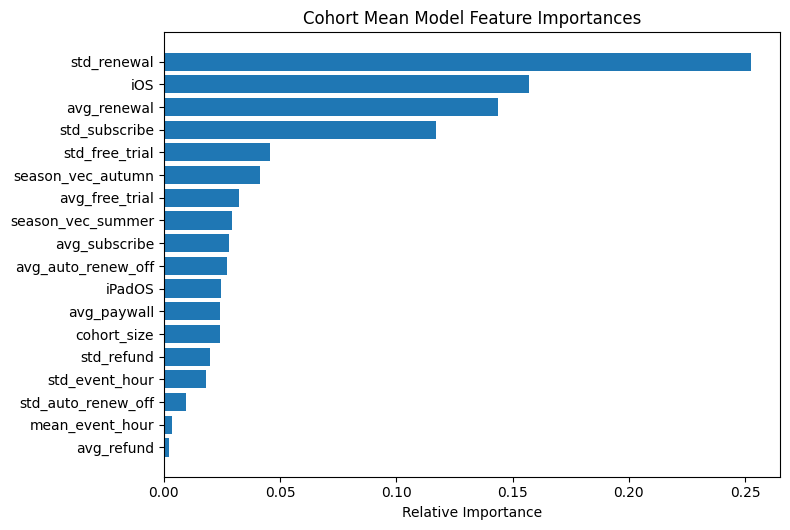

In [12]:
# Build pandas DataFrame
df_fi = pd.DataFrame({
    "feature":    feature_names,
    "importance": importances
}).query("importance > 0").sort_values("importance", ascending=False)

# Plot
top_n = min(20, len(df_fi))
plt.figure(figsize=(8, top_n * 0.3))
plt.barh(df_fi.feature.iloc[:top_n][::-1], df_fi.importance.iloc[:top_n][::-1])
plt.title("Cohort Mean Model Feature Importances")
plt.xlabel("Relative Importance")
plt.tight_layout()
plt.show()

Cohort-level (Std Model) Feature Importance

In [13]:
bestModelStd  = PipelineModel.load("/Users/macbookpro/PyCharmMiscProject/models/cohort_std_model")

In [14]:
# pull out the GBT stage
gbt_std = next(s for s in bestModelStd.stages
                if isinstance(s, GBTRegressionModel))

# use the test set
feat_df = bestModelStd.transform(test.limit(1)).select("features")

# read feature names from metadata
meta = feat_df.schema["features"].metadata
attrs = meta["ml_attr"]["attrs"]
# flatten all attr groups (numeric, binary, etc.)
feature_names = [item["name"] for group in attrs.values() for item in group]

# get importances
importances = gbt_std.featureImportances.toArray().tolist()

assert len(feature_names) == len(importances), "Lengths still mismatch!"

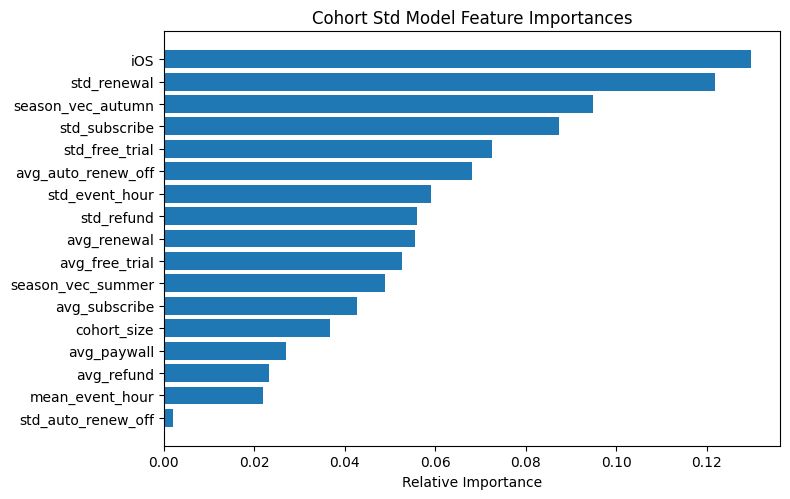

In [15]:
# 6) build pandas DataFrame
df_fi = pd.DataFrame({
    "feature":    feature_names,
    "importance": importances
}).query("importance > 0").sort_values("importance", ascending=False)

# 7) plot
top_n = min(20, len(df_fi))
plt.figure(figsize=(8, top_n * 0.3))
plt.barh(df_fi.feature.iloc[:top_n][::-1], df_fi.importance.iloc[:top_n][::-1])
plt.title("Cohort Std Model Feature Importances")
plt.xlabel("Relative Importance")
plt.tight_layout()
plt.show()

Note that the Feature Importance is shown for the ones that are > 0

# Cohort-level Residuals & Deciles

In [16]:
from pyspark.sql.window import Window
from pyspark.storagelevel import StorageLevel

In [17]:
# Unpersist cached old DF it so Spark forgets those part-files
try:
    cohortPreds.unpersist()
except NameError:
    pass

# Re-load the cohortPreds DataFrame from disk (fresh, uncached)
cohortPreds = spark.read.parquet(
    "/Users/macbookpro/PyCharmMiscProject/Output_Dataframes/cohort_preds.parquet"
)

# Cache it again for speed
cohortPreds = cohortPreds.persist(StorageLevel.MEMORY_AND_DISK)

25/07/27 22:13:05 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [18]:
cohortPreds.printSchema()

root
 |-- avg_auto_renew_off: double (nullable = true)
 |-- avg_free_trial: double (nullable = true)
 |-- avg_paywall: double (nullable = true)
 |-- avg_refund: double (nullable = true)
 |-- avg_renewal: double (nullable = true)
 |-- avg_stickiness_ratio: double (nullable = true)
 |-- avg_subscribe: double (nullable = true)
 |-- cohort_index: long (nullable = true)
 |-- cohort_season: string (nullable = true)
 |-- cohort_size: long (nullable = true)
 |-- first_event_date: string (nullable = true)
 |-- iOS: double (nullable = true)
 |-- iPadOS: double (nullable = true)
 |-- mean_event_hour: double (nullable = true)
 |-- mean_revenue_15d: double (nullable = true)
 |-- mean_revenue_1y: double (nullable = true)
 |-- std_auto_renew_off: double (nullable = true)
 |-- std_event_hour: double (nullable = true)
 |-- std_free_trial: double (nullable = true)
 |-- std_paywall: double (nullable = true)
 |-- std_refund: double (nullable = true)
 |-- std_renewal: double (nullable = true)
 |-- std_reve

In [20]:
# Compute residuals
res = (cohortPreds
       .withColumn("residual_mean", F.col("pred15_mean") - F.col("mean_revenue_15d"))
       .withColumn("residual_std",  F.col("pred15_std")  - F.col("std_revenue_15d"))
      )

# Summary statistics
res.select(
    F.avg("residual_mean").alias("mean_residual_mean"),
    F.stddev("residual_mean").alias("std_residual_mean"),
    F.expr("percentile_approx(residual_mean, 0.5)").alias("median_residual_mean"),
    F.avg("residual_std").alias("mean_residual_std"),
    F.stddev("residual_std").alias("std_residual_std"),
    F.expr("percentile_approx(residual_std, 0.5)").alias("median_residual_std")
).show(truncate=False)

+---------------------+------------------+--------------------+---------------------+------------------+---------------------+
|mean_residual_mean   |std_residual_mean |median_residual_mean|mean_residual_std    |std_residual_std  |median_residual_std  |
+---------------------+------------------+--------------------+---------------------+------------------+---------------------+
|-0.015945621123277815|0.0191302662550781|-0.01669479455925954|-0.016323819738317424|0.1312874147221109|-0.015418497186169944|
+---------------------+------------------+--------------------+---------------------+------------------+---------------------+



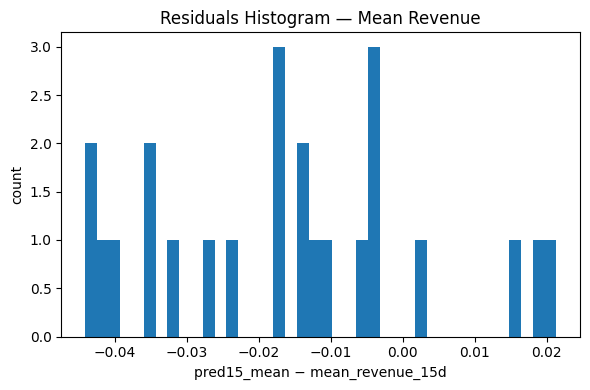

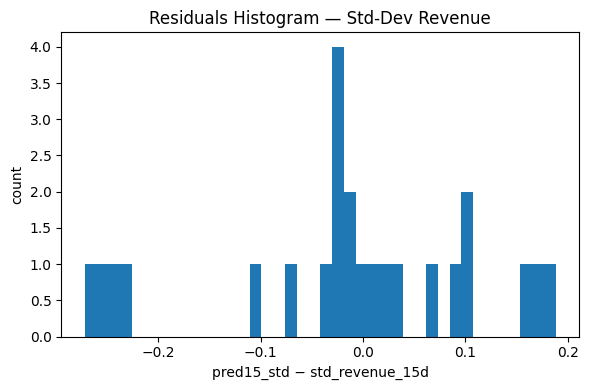

In [21]:
# Histograms of residuals (via pandas)
res_pd = res.select("residual_mean", "residual_std").toPandas()

plt.figure(figsize=(6,4))
plt.hist(res_pd.residual_mean, bins=40)
plt.title("Residuals Histogram — Mean Revenue")
plt.xlabel("pred15_mean − mean_revenue_15d")
plt.ylabel("count")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
plt.hist(res_pd.residual_std, bins=40)
plt.title("Residuals Histogram — Std‑Dev Revenue")
plt.xlabel("pred15_std − std_revenue_15d")
plt.ylabel("count")
plt.tight_layout()
plt.show()